GDCV 04 이미지 어디까지 우려볼까?

프로젝트: CutMix 또는 Mixup 비교실험 하기

<<목차>>


1) Augmentation을 적용한 데이터셋 만들기

2) 모델 만들기

3) 모델 훈련하기

4) 훈련 과정 시각화하기

5) Augmentation에 의한 모델 성능 비교

6) 루브릭

7) 회고

In [106]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [107]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1. Augmentation을 적용한 데이터셋 만들기

In [108]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [109]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})


In [110]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))  # tf.Tensor(18610, shape=(), dtype=int64)
print(tf.data.experimental.cardinality(ds_test))  # tf.Tensor(4652, shape=(), dtype=int64)

tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)


In [111]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

In [112]:
ds_info.features["label"].names

['n02085620-chihuahua',
 'n02085782-japanese_spaniel',
 'n02085936-maltese_dog',
 'n02086079-pekinese',
 'n02086240-shih-tzu',
 'n02086646-blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-rhodesian_ridgeback',
 'n02088094-afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-walker_hound',
 'n02089973-english_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-irish_wolfhound',
 'n02091032-italian_greyhound',
 'n02091134-whippet',
 'n02091244-ibizan_hound',
 'n02091467-norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-saluki',
 'n02092002-scottish_deerhound',
 'n02092339-weimaraner',
 'n02093256-staffordshire_bullterrier',
 'n02093428-american_staffordshire_terrier',
 'n02093647-bedlington_terrier',
 'n02093754-border_terrier',
 'n02093859-kerry_blue_terrier',
 'n02093991-irish_terrier',
 'n02094114-norfolk_terrier',
 'n02094258-norwi

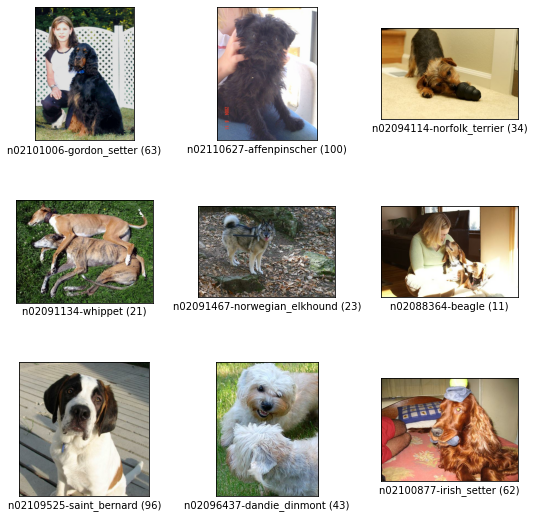

In [113]:
fig = tfds.show_examples(ds_train, ds_info)

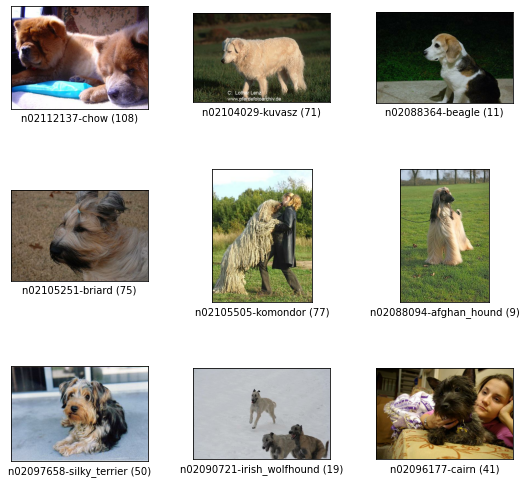

In [114]:
fig = tfds.show_examples(ds_test, ds_info)

In [115]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [116]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [117]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [118]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [119]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [120]:
def cutmix(image, label, prob=1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [121]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [122]:
def mixup(image, label, prob=1.0, batch_size=8, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [123]:
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [124]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=8, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [125]:
# BATCH_SIZE = 8

strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 8 * strategy.num_replicas_in_sync

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [126]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)

In [127]:
# 데이터셋에서 이미지 가져와서 시각화
def draw_ds_train(ds_train, batch_size=8, row=6, col=4):
    row = min(row, batch_size//col)  # row 재설정
    
    # 데이터셋에서 배치 사이즈(=16개)만큼 1번만 이미지 가져오기
    for i, (image, label) in enumerate(ds_train.take(1)):
        
        plt.figure(figsize=(8,int(8*row/col)))  # 8x8 크기
        for j in range(row*col):
            plt.subplot(row,col,j+1)
            plt.axis('off')
            plt.imshow(image[j,])  # 가져온 이미지(16개) 하나씩 출력
                    
        plt.tight_layout()
        plt.show()

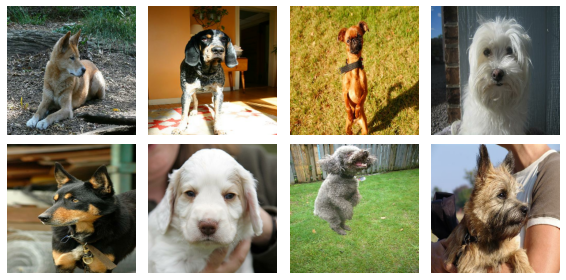

In [128]:
draw_ds_train(ds_train_no_aug, BATCH_SIZE)

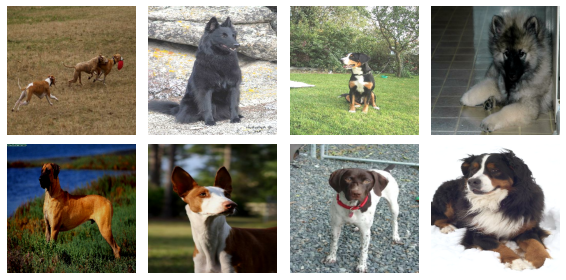

In [129]:
draw_ds_train(ds_train_aug, BATCH_SIZE)

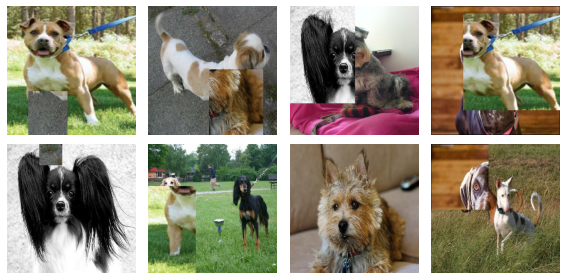

In [130]:
draw_ds_train(ds_train_aug_cutmix, BATCH_SIZE)

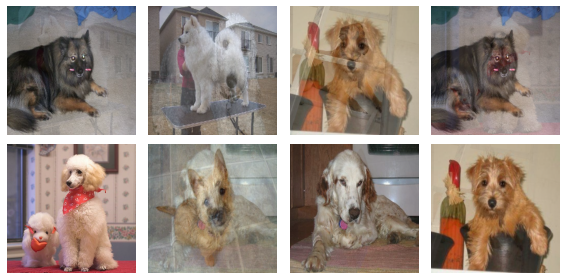

In [131]:
draw_ds_train(ds_train_aug_mixup, BATCH_SIZE)

2) 모델 만들기

In [132]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [133]:
resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_no_aug 으로 학습시킬 ResNet
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug 으로 학습시킬 ResNet
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_cutmix 으로 학습시킬 ResNet
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_mixup 으로 학습시킬 ResNet

3) 모델 훈련하기

In [134]:
EPOCH = 10

LEARNING_RATE = 0.01

Learning rate schedule: 0.001 to 0.05 to 0.000819


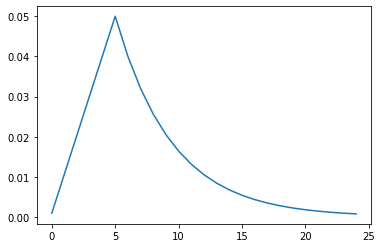

In [135]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [136]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=8,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

In [137]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1500/1500 [==============================] - 124s 80ms/step - loss: 4.0436 - accuracy: 0.1448 - val_loss: 2.4436 - val_accuracy: 0.4143 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
1500/1500 [==============================] - 119s 80ms/step - loss: 1.9569 - accuracy: 0.4690 - val_loss: 1.7821 - val_accuracy: 0.5199 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
1500/1500 [==============================] - 120s 80ms/step - loss: 1.5788 - accuracy: 0.5483 - val_loss: 2.5242 - val_accuracy: 0.3853 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
1500/1500 [==============================] - 119s 80ms/step - loss: 1.4266 - accuracy: 0.5851 - val_loss: 3.0617 - val_accuracy: 0.3285 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
1500/1500 [==============

In [138]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1500/1500 [==============================] - 123s 80ms/step - loss: 4.0100 - accuracy: 0.1542 - val_loss: 2.3869 - val_accuracy: 0.4095 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
1500/1500 [==============================] - 120s 80ms/step - loss: 2.0469 - accuracy: 0.4461 - val_loss: 2.1106 - val_accuracy: 0.4513 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
1500/1500 [==============================] - 119s 80ms/step - loss: 1.7188 - accuracy: 0.5185 - val_loss: 3.8756 - val_accuracy: 0.2578 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
1500/1500 [==============================] - 119s 79ms/step - loss: 1.6239 - accuracy: 0.5371 - val_loss: 3.1516 - val_accuracy: 0.2718 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
1500/1500 [==============

In [139]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1500/1500 [==============================] - 125s 81ms/step - loss: 4.7310 - accuracy: 0.0375 - val_loss: 3.5738 - val_accuracy: 0.1927 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
1500/1500 [==============================] - 122s 81ms/step - loss: 3.5693 - accuracy: 0.2508 - val_loss: 2.0237 - val_accuracy: 0.4583 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
1500/1500 [==============================] - 122s 81ms/step - loss: 3.1880 - accuracy: 0.3414 - val_loss: 2.0069 - val_accuracy: 0.4712 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
1500/1500 [==============================] - 122s 81ms/step - loss: 3.0351 - accuracy: 0.3787 - val_loss: 2.2546 - val_accuracy: 0.4291 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
1500/1500 [==============

In [140]:
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
1500/1500 [==============================] - 126s 82ms/step - loss: 4.6518 - accuracy: 0.0508 - val_loss: 3.3656 - val_accuracy: 0.2217 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/10
1500/1500 [==============================] - 123s 82ms/step - loss: 3.5321 - accuracy: 0.2648 - val_loss: 2.1548 - val_accuracy: 0.4383 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/10
1500/1500 [==============================] - 122s 81ms/step - loss: 3.1644 - accuracy: 0.3596 - val_loss: 2.8090 - val_accuracy: 0.3233 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/10
1500/1500 [==============================] - 122s 81ms/step - loss: 3.0217 - accuracy: 0.4091 - val_loss: 3.8883 - val_accuracy: 0.1941 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/10
1500/1500 [==============

4) 훈련 과정 시각화하기

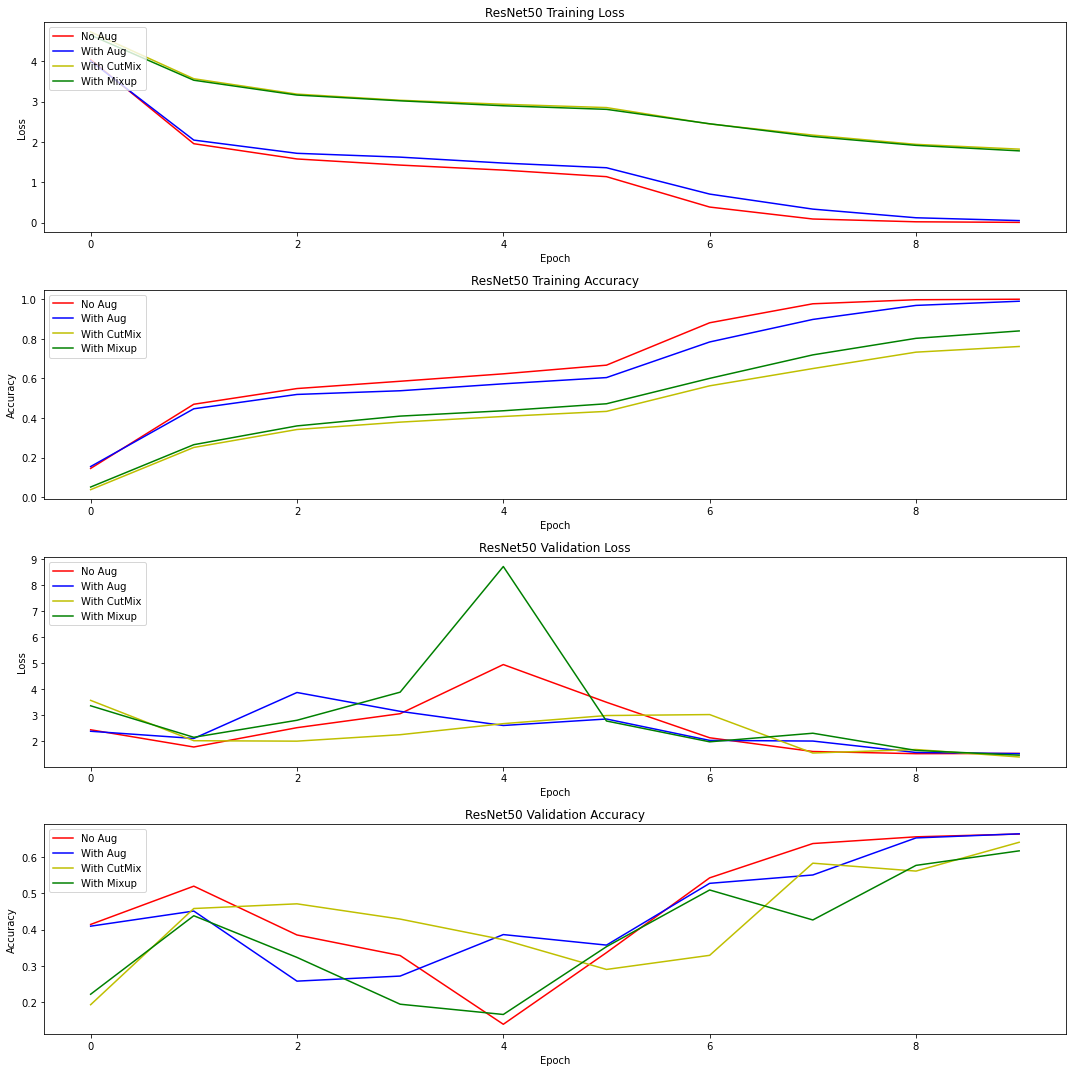

In [143]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

plt.tight_layout()
plt.savefig('/home/june/Github/GDCV/data/gd04/Results_With_all_Aug.png')  # 저장
plt.show()

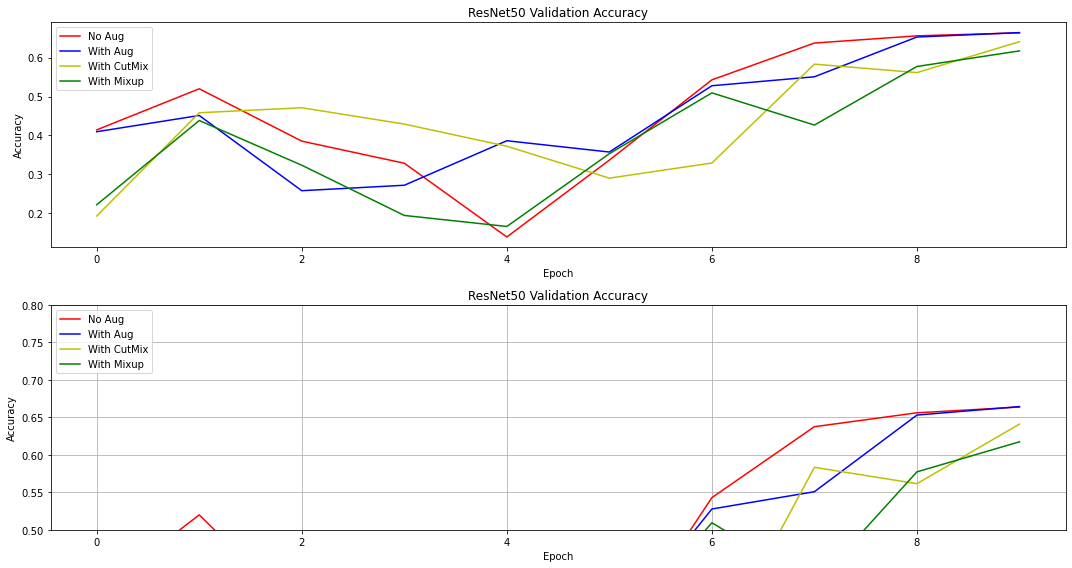

In [145]:
plt.subplots(figsize=(15,8))

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화
plt.subplot(211)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup Validation Accuracy 시각화 2
plt.subplot(212)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 

plt.tight_layout()
plt.savefig('/home/june/Github/GDCV/data/gd04/Validation_Accuracy_With_Aug.png')  # 저장
plt.show()

5) Augmentation에 의한 모델 성능 비교

In [146]:
def get_df_resnet50_result(col='val_accuracy'):
    # ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 저장
    resnet50 = {
        'No Aug': history_resnet50_no_aug.history[col],
        'With Aug': history_resnet50_aug.history[col],
        'With CutMix': history_resnet50_aug_cutmix.history[col],
        'With Mixup': history_resnet50_aug_mixup.history[col]
    }

    # 데이터 프레임으로 생성
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCH)])
    return df_resnet50

In [147]:
df_resnet50_loss = get_df_resnet50_result('loss')
df_resnet50_loss

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,4.043642,4.009951,4.731025,4.651768
EPOCHS_1,1.956904,2.046943,3.569345,3.532125
EPOCHS_2,1.578754,1.718838,3.187956,3.164437
EPOCHS_3,1.426634,1.623945,3.035104,3.021683
EPOCHS_4,1.302128,1.476676,2.935752,2.898823
EPOCHS_5,1.139229,1.360691,2.853737,2.809774
EPOCHS_6,0.385301,0.707171,2.447251,2.451975
EPOCHS_7,0.088789,0.334258,2.171062,2.136030
EPOCHS_8,0.019589,0.119581,1.941167,1.915956
EPOCHS_9,0.005120,0.049514,1.822664,1.779607


In [148]:
df_resnet50_acc = get_df_resnet50_result('accuracy')
df_resnet50_acc

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,0.144833,0.154250,0.037500,0.050833
EPOCHS_1,0.469000,0.446083,0.250750,0.264750
EPOCHS_2,0.548250,0.518500,0.341417,0.359583
EPOCHS_3,0.585083,0.537083,0.378667,0.409083
EPOCHS_4,0.622583,0.572167,0.407250,0.436000
EPOCHS_5,0.666417,0.603667,0.432917,0.471417
EPOCHS_6,0.880500,0.783500,0.562000,0.599667
EPOCHS_7,0.976417,0.897333,0.649250,0.718333
EPOCHS_8,0.996833,0.968167,0.732083,0.801917
EPOCHS_9,0.999417,0.989250,0.760667,0.839250


In [149]:
df_resnet50_val_loss = get_df_resnet50_result('val_loss')
df_resnet50_val_loss

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,2.443570,2.386870,3.573778,3.365646
EPOCHS_1,1.782075,2.110626,2.023658,2.154793
EPOCHS_2,2.524178,3.875606,2.006866,2.809017
EPOCHS_3,3.061667,3.151621,2.254582,3.888311
EPOCHS_4,4.948719,2.608737,2.679107,8.714684
EPOCHS_5,3.500620,2.857244,2.990752,2.780874
EPOCHS_6,2.136978,2.035292,3.027690,1.981060
EPOCHS_7,1.609207,2.010567,1.550681,2.311356
EPOCHS_8,1.525310,1.572131,1.685515,1.650977
EPOCHS_9,1.535435,1.526656,1.398946,1.468292


In [150]:
df_resnet50_val_acc = get_df_resnet50_result('val_accuracy')
df_resnet50_val_acc

,No Aug,With Aug,With CutMix,With Mixup
EPOCHS_0,0.414296,0.409515,0.192747,0.221665
EPOCHS_1,0.519939,0.451259,0.458256,0.438316
EPOCHS_2,0.385261,0.257812,0.471199,0.323344
EPOCHS_3,0.328475,0.271805,0.429104,0.194146
EPOCHS_4,0.138759,0.386311,0.372202,0.165812
EPOCHS_5,0.336521,0.357276,0.290112,0.352962
EPOCHS_6,0.542910,0.527752,0.329058,0.509445
EPOCHS_7,0.637593,0.550840,0.583372,0.426656
EPOCHS_8,0.656133,0.653102,0.561567,0.577309
EPOCHS_9,0.663829,0.664412,0.641091,0.617421


In [151]:
# ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 평균값을 딕셔너리로 저장
resnet50_result = {
    'loss': round(df_resnet50_loss.mean(),2),
    'accuracy': round(df_resnet50_acc.mean(),2),
    'val_losss': round(df_resnet50_val_loss.mean(),2),
    'val_accuracy': round(df_resnet50_val_acc.mean(),2),
}

# 데이터 프레임 생성
df_resnet50_result = pd.DataFrame(resnet50_result)
df_resnet50_result

,loss,accuracy,val_losss,val_accuracy
No Aug,1.19,0.69,2.51,0.46
With Aug,1.34,0.65,2.41,0.45
With CutMix,2.87,0.46,2.32,0.43
With Mixup,2.84,0.50,3.11,0.38


In [152]:
df_resnet50_result['val_accuracy']

No Aug         0.46
With Aug       0.45
With CutMix    0.43
With Mixup     0.38
Name: val_accuracy, dtype: float64

In [153]:
df_resnet50_result

,loss,accuracy,val_losss,val_accuracy
No Aug,1.19,0.69,2.51,0.46
With Aug,1.34,0.65,2.41,0.45
With CutMix,2.87,0.46,2.32,0.43
With Mixup,2.84,0.50,3.11,0.38


6) 루브릭

1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?

CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.


2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?

각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술하였음


3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?

기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.

7) 회고

- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**